## Quantum Walk operator for a line with 16 nodes

This notebook is a practical implementation of the quantum random walk, analogous to the classical random walk. This algorithm is important as it keep the potential of providing speed-ups for different quantum algorithms.

In [7]:
from classiq import *

size = 4

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)


def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0 for i in range(2**size)]
    if i == 0:
        prob[i + 1] = 1.0
    elif i == ((2**size) - 1):
        prob[i - 1] = 1.0
    else:
        prob[i + 1] = 0.5
        prob[i - 1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        C_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

The code starts by  initializing the number of qubits required for describing the states of the system. In the problem statement, there are a total of 16 nodes, and to represent these 16 states, we need a minimum of $log_2 16 = 4$ qubits

We define the prepare_minus function required by the the zero diffuzer to construct the transformation unitary operator. This operator is analogous to the coin operator in classical random walk. The C_operator function uses the C_iteration function which sets the probabilities in the case of each of the states. The combined operator created from theses functions is a controlled operator so that it applies only that particular operation corresponding to the current state of the system, just as we want. This operator is like a squeezed form of the multiple 'if' statements for the different possible states. 

Similarly, we do this for the edges now. The edge_oracle function encodes the qubits adjacent to each of the qubits. This is then operated on by the SWAP operator to help reflect the required changes in the state of the system. This reflection fo changes is done by S_operator or the Shift Operator.

Finally, we use all these functions to construct the main circuit for the stated problem statement.

We first allocate 4 qubits to the vertices variable. However, we have to represent all the vertices and so, we put these 4 qubits in superposition using Hadamard operators. We also allocate another 4 qubits to the adjacent_vertices variable, which maps all the adjacent vertices so that there state probability changes conditionally as mentioned for each of the system states. The results are:

In [8]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)
    
    C_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

The requred changes can be seen being applied in the circuit:

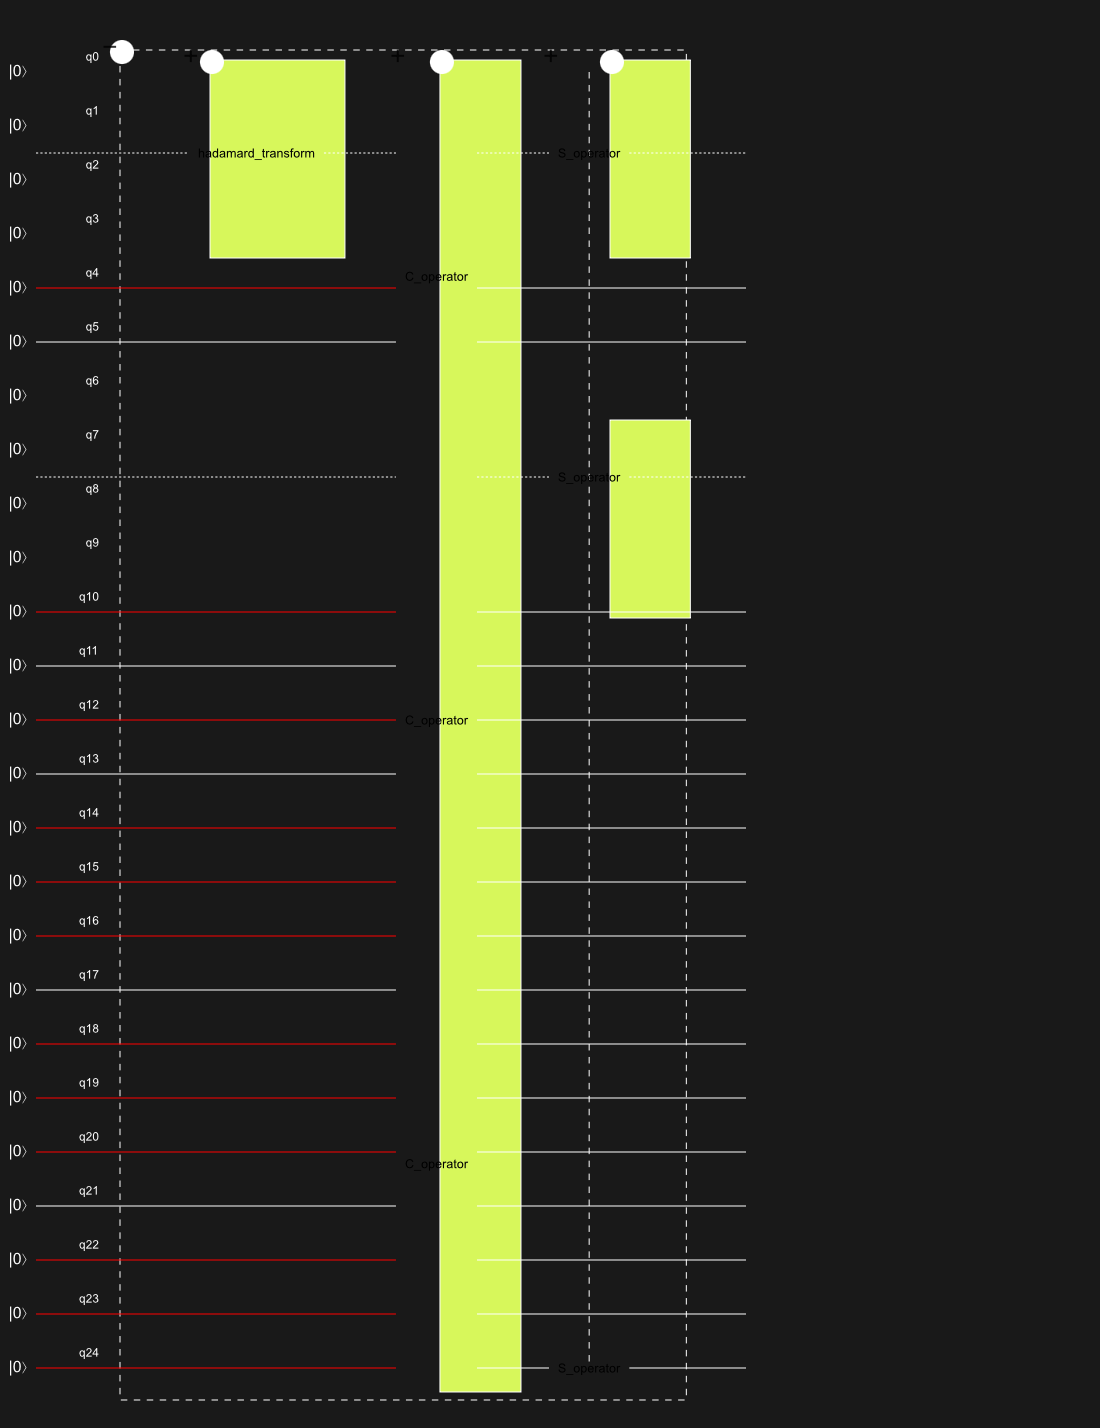

On expanding the cirucit, we can see the Coin Operator and Shift Operator blocks being implemented correctly:

Coin Operator:
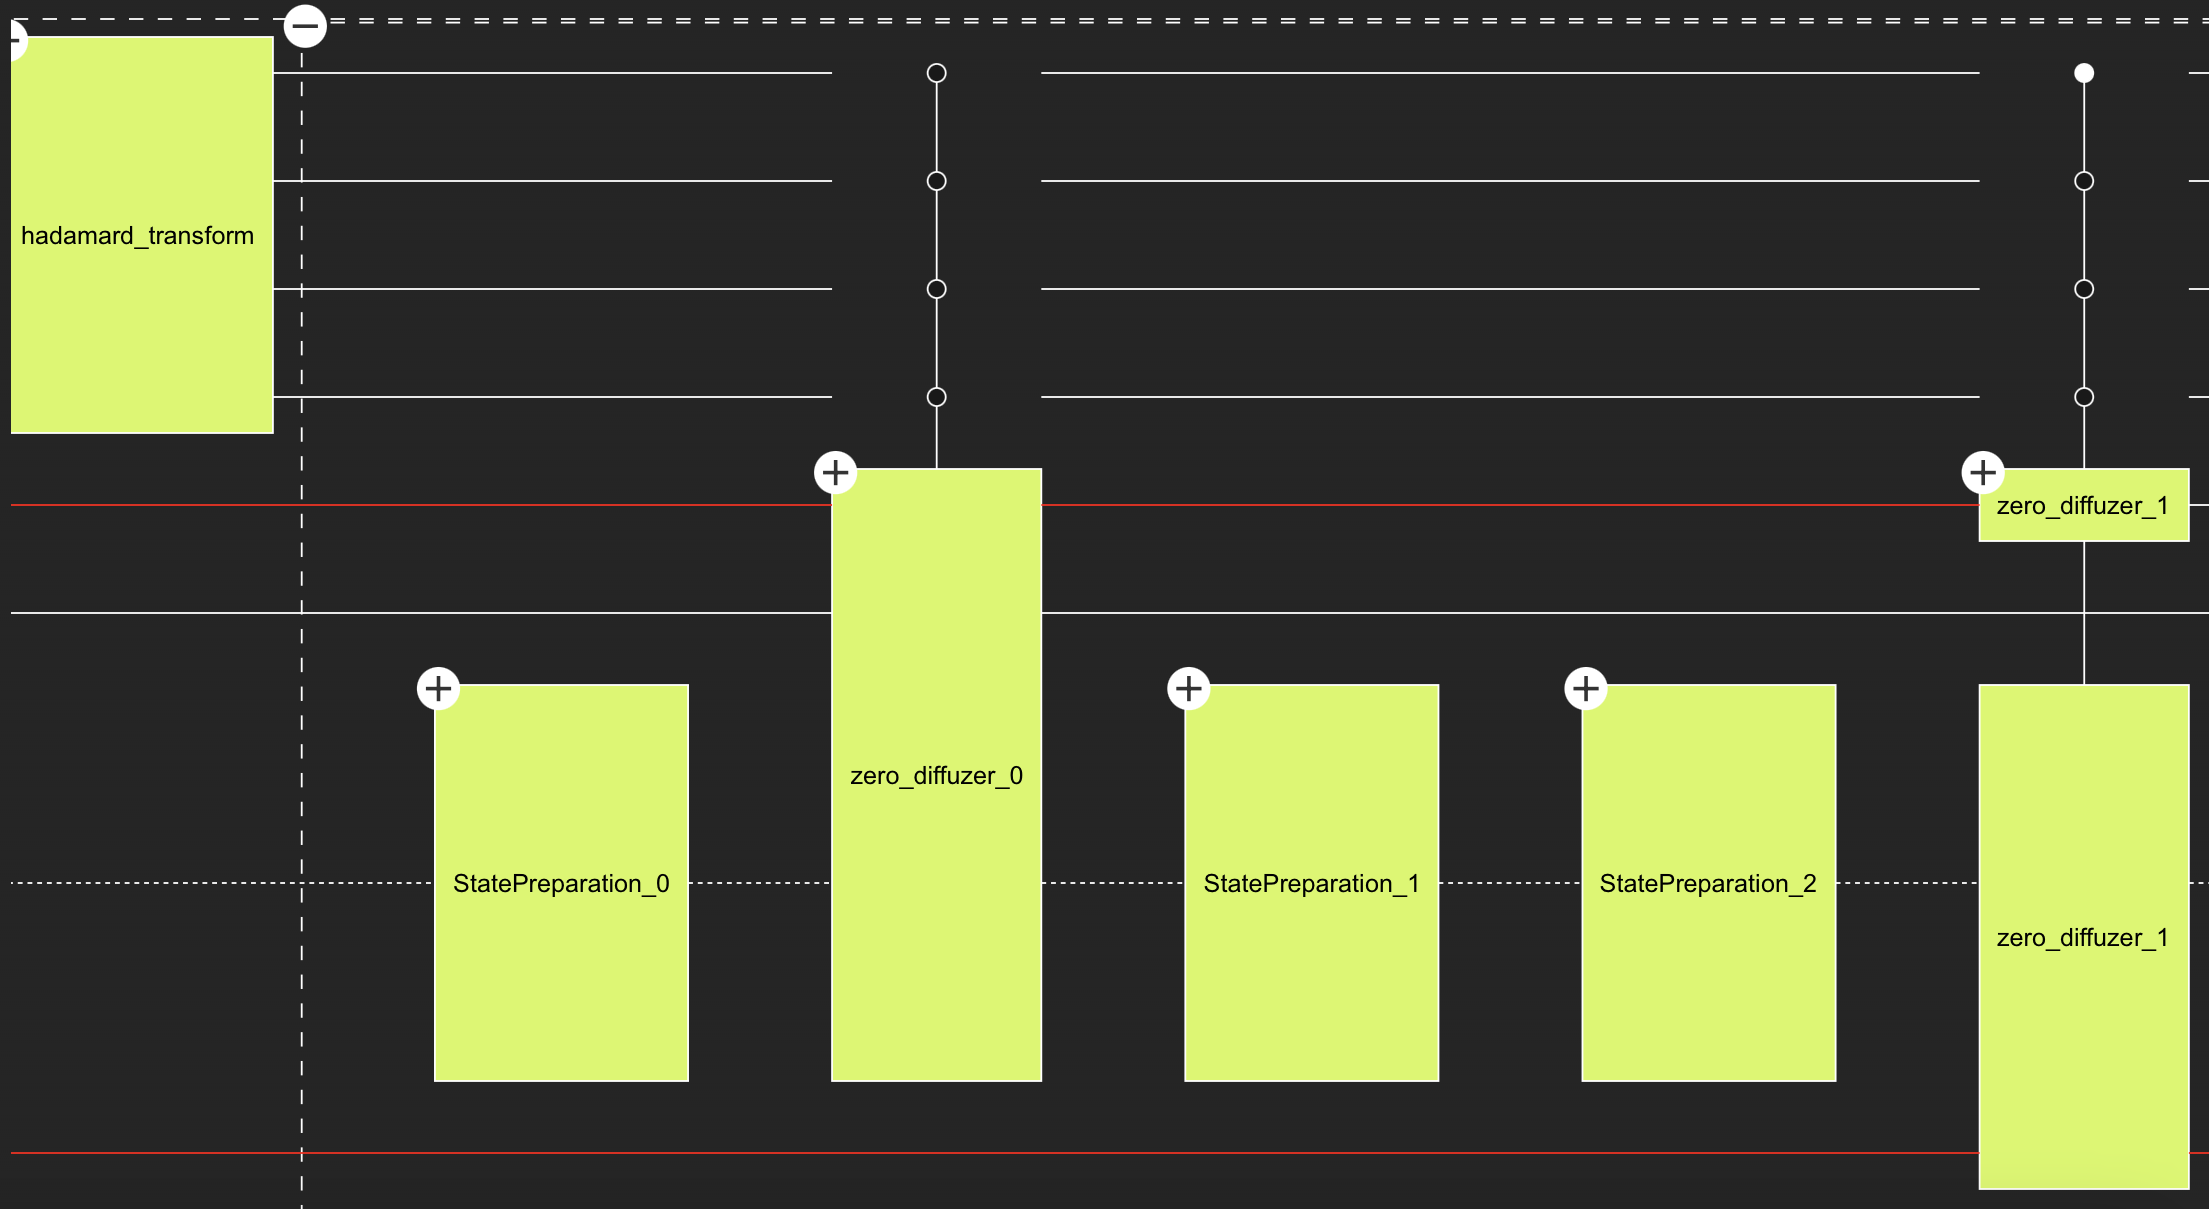

We can see that the fully expandde version is just this basic block being repeated for each of the states:
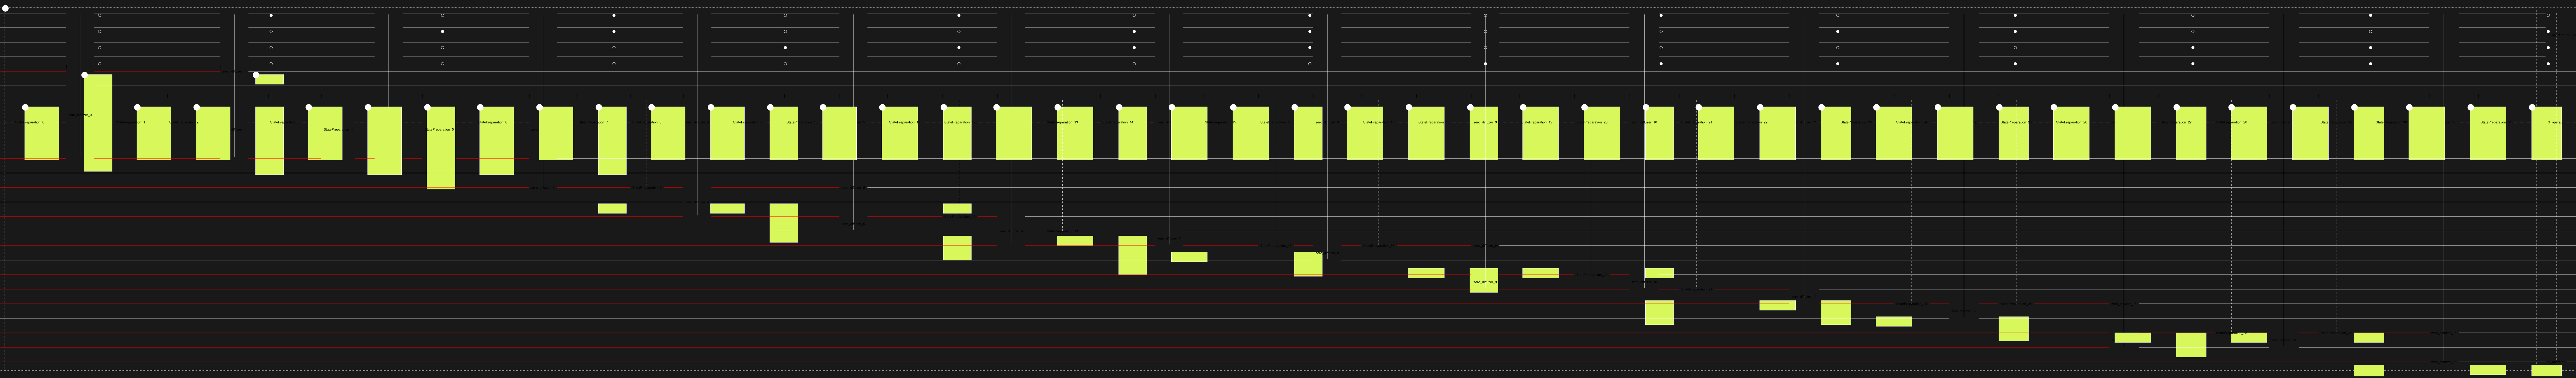

Shift Operator:
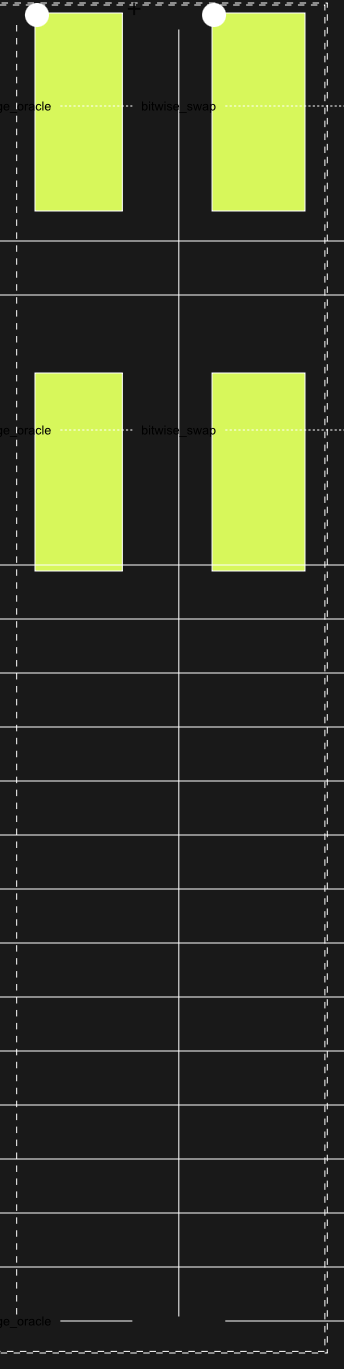

State Counts:
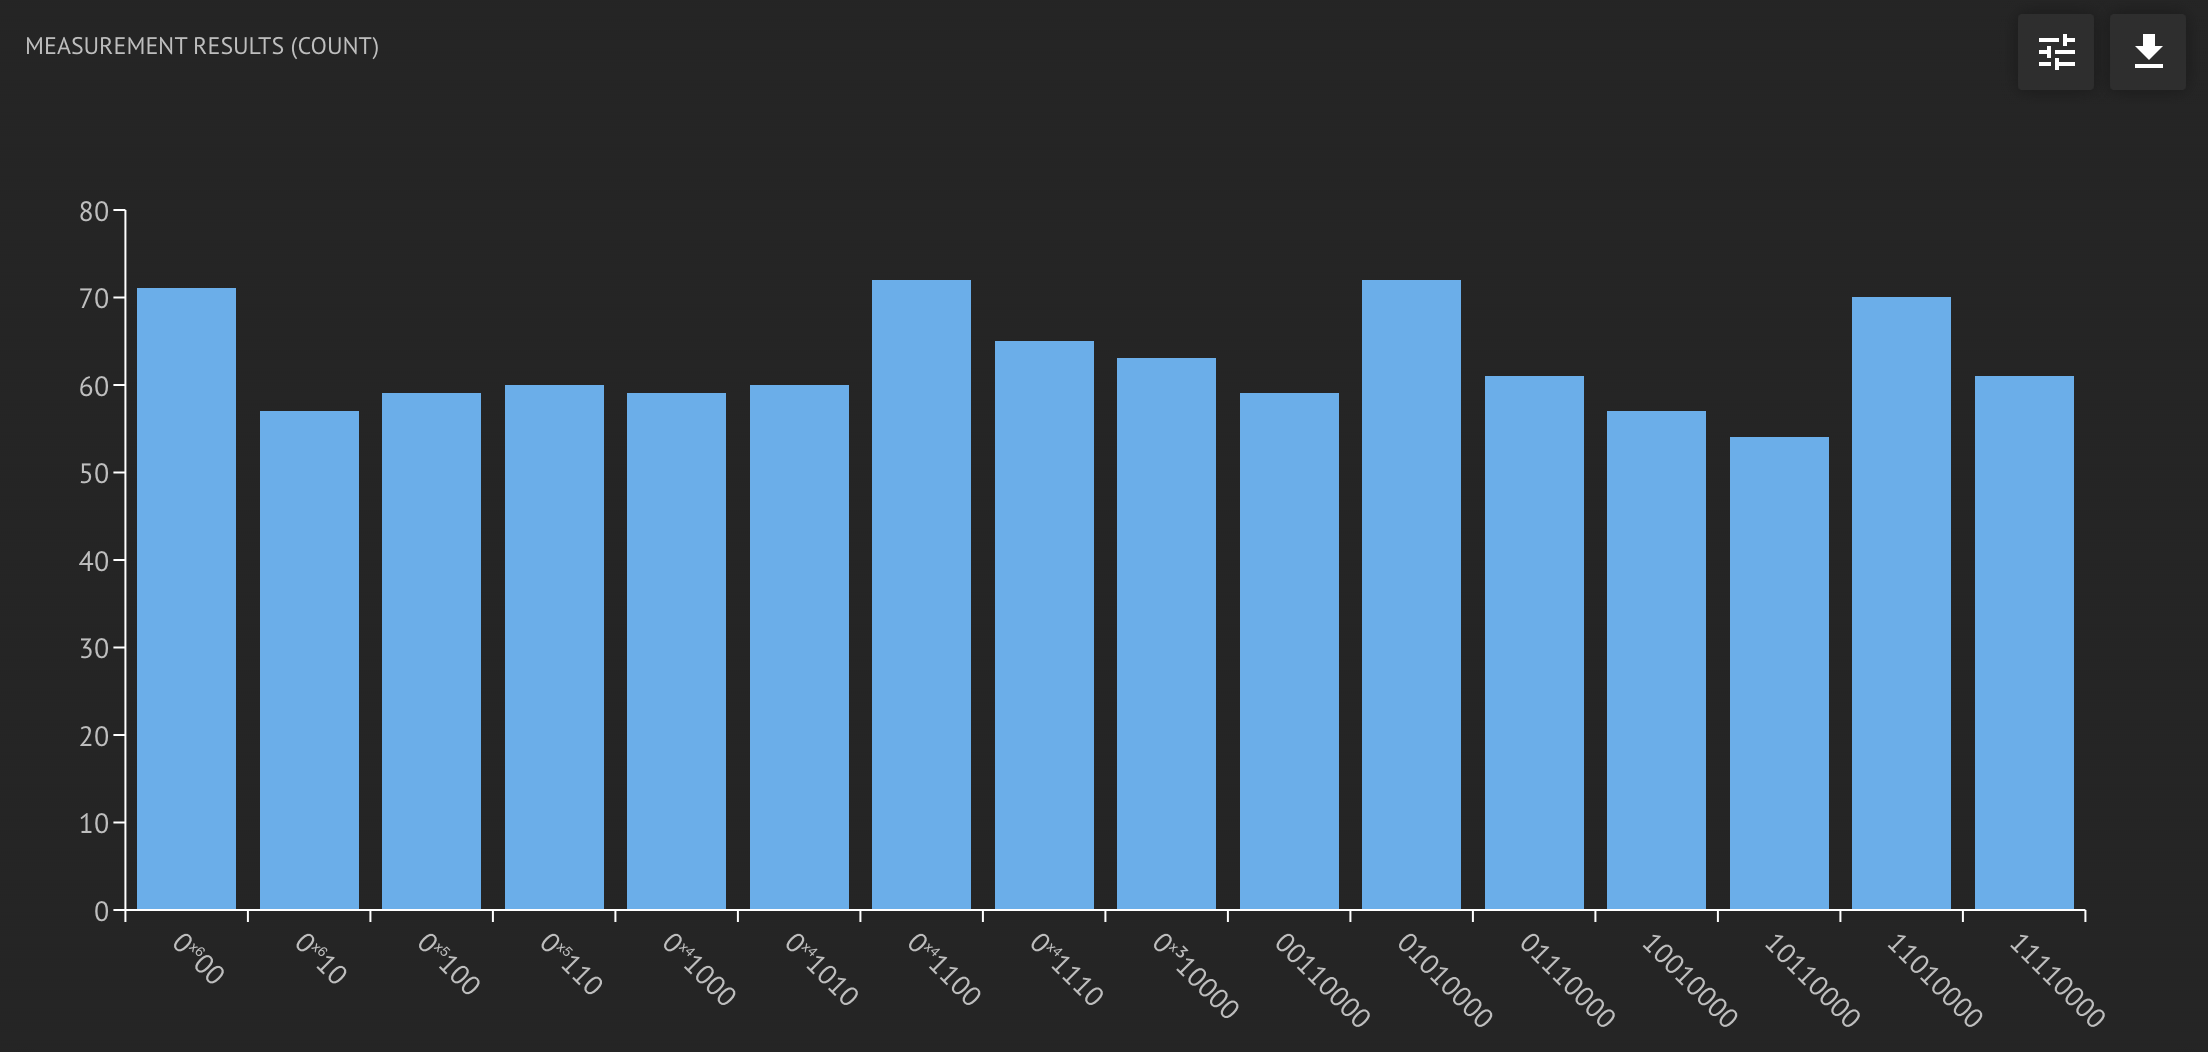